In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from scipy.stats import norm

In [2]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Alpha": "Average height"}, coord_map = {"Alpha_dim_0": {0:'Female', 1:'Male'}})

In [3]:
MUMEAN = 167
MUSTD  = 3
SIGMAUPPER = 10

ALPHA = 0.11

Data

In [4]:
Dat = pd.read_csv('Data/Howell1.csv', sep=';')
DatAdults = Dat[Dat['age'] >= 18].sort_values('weight').reset_index(drop=True) # We are interested in adult's height

---

$$
\begin{align*}\
h_i &\sim \textsf{Normal}(\mu_i,\sigma^2) \\
\mu_i &= \alpha + \beta_M M_i\\
\alpha &\sim \textsf{Normal}(167, 3^2) \\
\beta &\sim \textsf{Normal}(0, 3^2) \\
\sigma &\sim \textsf{Uniform}(0, 10).
\end{align*}
$$

We get a sample for the prior mean of the height if women and men.

In [5]:
NPrior= 10**4

PrioMuFemale = norm.rvs(size=NPrior, loc=MUMEAN, scale=MUSTD)
PrioMuMale = norm.rvs(size=NPrior, loc=MUMEAN, scale=MUSTD) + norm.rvs(size=NPrior, loc=0, scale=MUSTD)

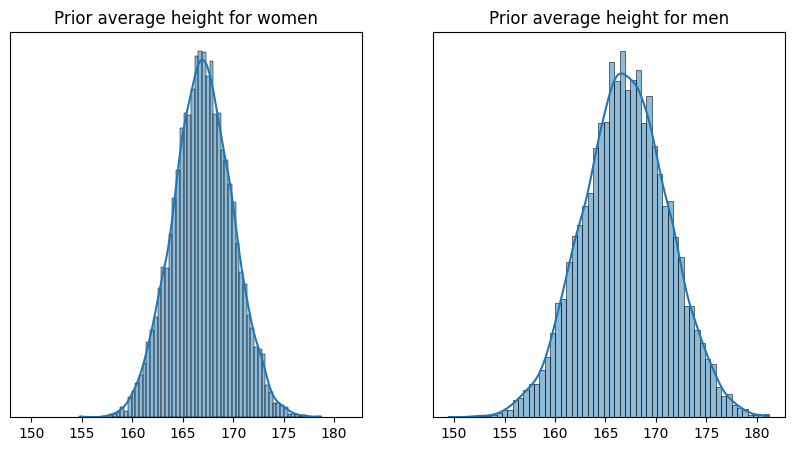

In [6]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))

sns.histplot(PrioMuFemale, ax=axs[0], kde=True, stat='density')
sns.histplot(PrioMuMale, ax=axs[1], kde=True, stat='density')

_ = axs[0].set_yticklabels('')
_ = axs[0].set_yticks([])
_ = axs[0].set_ylabel('')
_ = axs[0].set_title("Prior average height for women")

_ = axs[1].set_yticklabels('')
_ = axs[1].set_yticks([])
_ = axs[1].set_ylabel('')
_ = axs[1].set_title("Prior average height for men")

plt.savefig("PriorHeight.png", transparent=True)

Model with the index variable `Sex`:

$$
\begin{align*}\
h_i &\sim \textsf{Normal}(\mu_i,\sigma^2) \\
\mu_i &= \alpha_{\text{SEX}[i]}\\
\alpha_j &\sim \textsf{Normal}(167, 3^2) \\
\sigma &\sim \textsf{Uniform}(0, 10).
\end{align*}
$$

In [7]:
with pm.Model() as ModelHeightSex:
    Sigma = pm.Uniform("Sigma", 0, 50)
    Alpha = pm.Normal("Alpha", mu=170, sigma=10, shape=2)

    Mu = pm.Deterministic("Mu", Alpha[DatAdults['male']])

    Height = pm.Normal("Height", mu=Mu, sigma=Sigma, observed=DatAdults['height'])

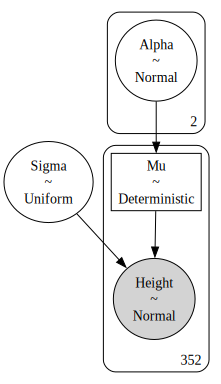

In [8]:
pm.model_to_graphviz(ModelHeightSex)

In [9]:
with ModelHeightSex:
    TraceHeightSex = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


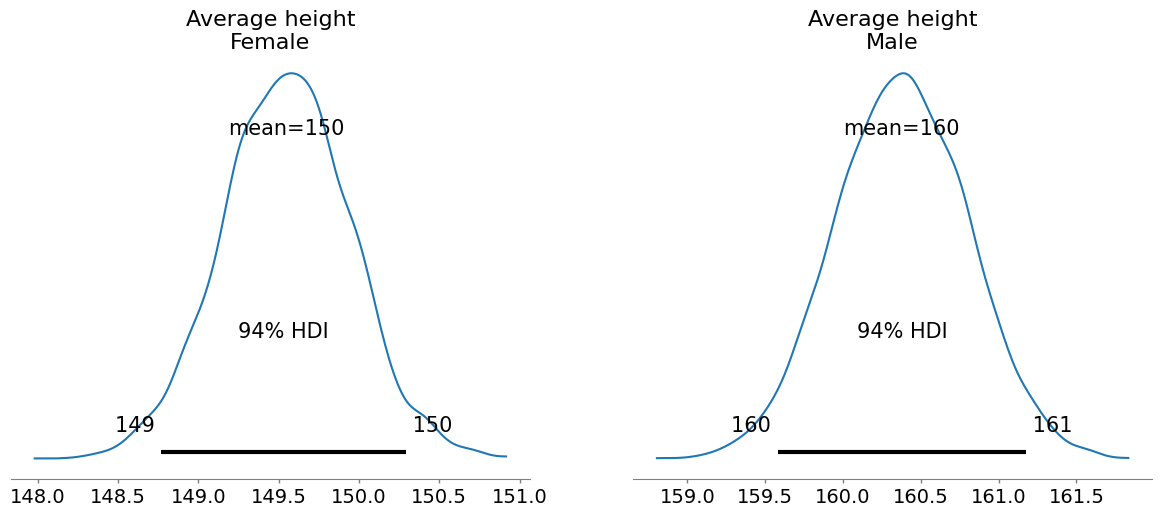

In [10]:
az.plot_posterior(TraceHeightSex, var_names=["Alpha"], labeller=labeller)

plt.savefig("PosteriorHeight.png", transparent=True)